In [3]:
import os
import sys
# sys.path.append(os.path.abspath(os.path.dirname(__file__)))  # ensures current directory is included
sys.path.append("/home/s27mhusa_hpc/Master-Thesis/XMI_Files")
import spacy
from collections import Counter
import json
input_label_dir = "/home/s27mhusa_hpc/Master-Thesis/Dataset19September/Test_BIO_labels_sentence"
input_token_dir = "/home/s27mhusa_hpc/Master-Thesis/Dataset19September/Test_BIO_tokens_sentence"

In [13]:
input_label_dir = "/home/s27mhusa_hpc/Master-Thesis/Dataset19September/Train_BIO_labels_Specific_sentence"
input_token_dir = "/home/s27mhusa_hpc/Master-Thesis/Dataset19September/Train_BIO_tokens__Specific_sentence"


city_list_path = "/home/s27mhusa_hpc/Master-Thesis/de_cities_list.json"
region_list_path = "/home/s27mhusa_hpc/Master-Thesis/de_regions_list.json"
country_list_path = "/home/s27mhusa_hpc/Master-Thesis/countries_list.json"

# Load the list of cities (lowercased for consistent comparison)
with open(city_list_path, "r", encoding="utf-8") as f:
    city_list = set(city.lower() for city in json.load(f))

with open(region_list_path, "r", encoding="utf-8") as f:
    region_list = set(region.lower() for region in json.load(f))

with open(country_list_path, "r", encoding="utf-8") as f:
    country_list = set(country.lower() for country in json.load(f))

all_labels = []

# Define soil-related labels to convert
soil_labels = [
    "soilAvailableNitrogen", "soilBulkDensity", "soilDepth", 
    "soilOrganicCarbon", "soilPH", "soilReferenceGroup", "soilTexture"
]

# Define labels to remove (convert to O)
remove_labels = ["cropVariety", "latitude", "longitude"]

for filename in os.listdir(input_label_dir):
    label_path = os.path.join(input_label_dir, filename)
    with open(label_path, "r", encoding="utf-8") as file:
        content = file.read()
    labels = eval(content)
    
    # labels = eval(content)  # list of BIO labels
    token_path = os.path.join(input_token_dir, f"tokens_{filename}")
    with open(token_path, "r", encoding="utf-8") as file:
        content = file.read()
    tokens = eval(content)

    i = 0
    while i < len(labels):
        label = labels[i]

        # Handle Location entities
        if label == "B-locationName":
            entity_tokens = [i]
            j = i + 1
            while j < len(labels) and labels[j] == "I-locationName":
                entity_tokens.append(j)
                j += 1
            entity_text = " ".join(tokens[k] for k in entity_tokens)
            
            # Check if entity is a known city
            if entity_text.lower() in city_list:
                labels[i] = "B-city"
                for k in entity_tokens[1:]:
                    labels[k] = "I-city"
            elif entity_text.lower() in region_list:
                labels[i] = "B-region"
                for k in entity_tokens[1:]:
                    labels[k] = "I-region"
            elif entity_text.lower() in country_list:
                labels[i] = "B-country"
                for k in entity_tokens[1:]:
                    labels[k] = "I-country"
            else:
                # If not found in any list, change as O
                labels[i] = "O"
                for k in entity_tokens[1:]:
                    labels[k] = "O"
            i = j
        
        # Handle soil-related entities
        elif any(label == f"B-{soil_label}" for soil_label in soil_labels):
            # Extract the soil label type (e.g., "soilAvailableNitrogen" from "B-soilAvailableNitrogen")
            soil_type = label[2:]  # Remove "B-" prefix
            entity_tokens = [i]
            j = i + 1
            while j < len(labels) and labels[j] == f"I-{soil_type}":
                entity_tokens.append(j)
                j += 1
            
            # Convert to generic Soil labels
            labels[i] = "B-Soil"
            for k in entity_tokens[1:]:
                labels[k] = "I-Soil"
            i = j
        
        # Handle labels to remove (convert to O)
        elif any(label == f"B-{remove_label}" for remove_label in remove_labels):
            # Extract the label type to remove
            remove_type = label[2:]  # Remove "B-" prefix
            entity_tokens = [i]
            j = i + 1
            while j < len(labels) and labels[j] == f"I-{remove_type}":
                entity_tokens.append(j)
                j += 1
            
            # Convert all tokens of this entity to O
            for k in entity_tokens:
                labels[k] = "O"
            i = j
        else:
            i += 1

    # all_labels.extend(labels)
    with open(label_path, "w", encoding="utf-8") as file:
        file.write(str(labels))

FileNotFoundError: [Errno 2] No such file or directory: '/home/s27mhusa_hpc/Master-Thesis/Dataset19September/Train_BIO_tokens__Specific_sentence/tokens_98829_sentence_010.txt'

In [14]:
from collections import Counter


all_labels = []
b_location_examples = []  # Store (label, token) pairs for B-locationName

for filename in os.listdir(input_label_dir):
    label_path = os.path.join(input_label_dir, filename)
    with open(label_path, "r", encoding="utf-8") as file:
        content = file.read()
    labels = eval(content)
    
    token_path = os.path.join(input_token_dir, f"tokens_{filename}")
    with open(token_path, "r", encoding="utf-8") as file:
        token_content = file.read()
    tokens = eval(token_content)

    # Extend for overall count
    all_labels.extend(labels)

    # Collect B-locationName examples
    for label, token in zip(labels, tokens):
        if label == "I-cropSpecies":
            b_location_examples.append((label, token))
            print(filename)

# Count only B- labels and strip B-
b_counts = Counter(label[2:] for label in all_labels if label.startswith("B-"))

# Print label counts
print("📊 B-Label Counts:")
for label, count in b_counts.items():
    print(f"{label}: {count}")

# Print all B-locationName examples
print("\n📍 Tokens with B-Soil:")
for label, token in b_location_examples:
    print(f"{label}: {token}")


FileNotFoundError: [Errno 2] No such file or directory: '/home/s27mhusa_hpc/Master-Thesis/Dataset19September/Train_BIO_tokens__Specific_sentence/tokens_98829_sentence_010.txt'

In [15]:
location_names = []
filenames = []

for filename in os.listdir(input_label_dir):
    label_path = os.path.join(input_label_dir, filename)
    with open(label_path, "r", encoding="utf-8") as file:
        content = file.read()
    labels = eval(content)

    token_path = os.path.join(input_token_dir, f"tokens_{filename}")
    with open(token_path, "r", encoding="utf-8") as file:
        tokens = eval(file.read())

    i = 0
    while i < len(labels):
        if labels[i] == "B-Crops":
            location_tokens = [tokens[i]]
            i += 1
            while i < len(labels) and labels[i] == "I-Crops":
                location_tokens.append(tokens[i])
                i += 1
            location_names.append(" ".join(location_tokens))
            filenames.append(filename)
        else:
            i += 1

# Print full location names
print("\n📍 Full Location Names:")
for loc in location_names:
    print(loc)
print("\n📍 Full filenames Names:")
for filename in filenames:
    print(filename)

FileNotFoundError: [Errno 2] No such file or directory: '/home/s27mhusa_hpc/Master-Thesis/Dataset19September/Train_BIO_tokens__Specific_sentence/tokens_98829_sentence_010.txt'

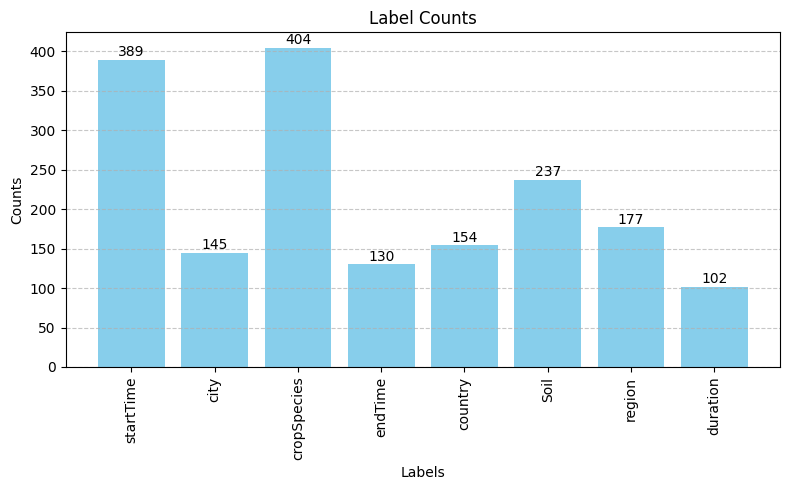

In [17]:
import matplotlib.pyplot as plt
# Extract labels and counts
labels = list(b_counts.keys())
counts = list(b_counts.values())

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color='skyblue')
plt.title("Label Counts")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=90)

# Add count labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.tight_layout()
plt.show()